# Benchmark model - Pastdue90- Exploration, calibration, test

This notebook uses as inputs the outputs from the pipeline ('05_preproc_pipeline_1.ipynb' notebook) and performs model calibration and general exploration for the transaction credit events prediction.

In [1]:
import pandas as pd
import numpy as np
import pickle
from os import environ

from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from scripts_viz.visualization_utils import *
from scripts_ml.models_utils import *

from bokeh.io import show, output_notebook
output_notebook()

import datetime as dt

Loading BokehJS ...

### TRAIN Data import

In [2]:
#importing data
user=environ["USERNAME"]
prefix = 'shuffle_p90_'
trainfile = '_traindata'
testfile = '_testdata'
postfix = '_19072_750'
preproc_folder = "benchmarks_shuffle"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'

[X_train, y_train, feature_labels] = pd.read_pickle(datafolder+prefix+trainfile+postfix+'.pkl') 
[X_test, y_test, feature_labels] = pd.read_pickle(datafolder+prefix+testfile+postfix+'.pkl') 

In [3]:
y_train.shape

(46095,)

In [4]:
X_train_df = pd.DataFrame(X_train, columns=feature_labels)
X_train_df.head()

,has_purchase,dd_value_date,cd_lent_c,cd_repaid_c,cd_impaired1_c,cd_pastdue90_c,cd_trend_a,c_lent_c,c_repaid_c,c_impaired1_c,...,d_pastdue90_c,d_trend_a,d_we_payment_share,invoice_amount,purchase_amount,currency_Britisches Pfund,currency_Euro,currency_Schweizer Franken,currency_US-Dollar,invoice_date
0,0.478098,-0.145273,-0.528606,-0.493910,-0.17567,-0.214037,-1.385604,-1.009960,-0.893308,-0.554907,...,-0.215463,-1.378706,0.117320,0.967374,0.678658,0.0,0.0,1.0,0.0,-1.870522
1,0.478098,-0.145273,-0.302102,-0.493910,-0.17567,-0.214037,-0.960531,-0.938481,-0.893308,-0.554907,...,-0.215463,-0.950582,0.117320,2.014475,0.905137,0.0,1.0,0.0,0.0,-0.606708
2,0.478098,-0.145273,-0.457419,-0.368922,-0.17567,-0.214037,0.997265,-0.922398,-0.788296,-0.554907,...,-0.215463,1.021271,-0.192621,-0.012316,0.466758,0.0,0.0,1.0,0.0,0.315048
3,0.478098,-0.145273,-0.502720,-0.460580,-0.17567,-0.214037,1.624837,-0.989410,-0.861077,-0.554907,...,-0.215463,1.653350,-0.192621,-0.829188,0.290076,0.0,0.0,1.0,0.0,0.675109
4,0.478098,-0.145273,-0.522134,-0.443915,-0.17567,-0.214037,1.315468,0.274891,0.239989,0.079527,...,-0.215463,1.341759,-0.192621,1.362819,0.764189,0.0,0.0,1.0,0.0,0.523883


In [5]:
X_train_df.columns

Index(['has_purchase', 'dd_value_date', 'cd_lent_c', 'cd_repaid_c',
       'cd_impaired1_c', 'cd_pastdue90_c', 'cd_trend_a', 'c_lent_c',
       'c_repaid_c', 'c_impaired1_c', 'c_pastdue90_c', 'c_trend_a',
       'cd_lent_c', 'd_repaid_c', 'd_impaired1_c', 'd_pastdue90_c',
       'd_trend_a', 'd_we_payment_share', 'invoice_amount', 'purchase_amount',
       'currency_Britisches Pfund', 'currency_Euro',
       'currency_Schweizer Franken', 'currency_US-Dollar', 'invoice_date'],
      dtype='object')

In [6]:
X_train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
has_purchase,46095.0,-2.067704e-08,1.000011,-2.091622,0.478098,0.478098,0.478098,0.478098
dd_value_date,46095.0,3.199733e-09,1.000011,-0.145273,-0.145273,-0.145273,-0.145273,85.601524
cd_lent_c,46095.0,1.108227e-09,1.000011,-0.567435,-0.528606,-0.431533,-0.017355,4.393315
cd_repaid_c,46095.0,-1.870823e-08,1.000011,-0.493910,-0.493910,-0.418917,-0.093949,4.377090
cd_impaired1_c,46095.0,-1.428856e-10,1.000011,-0.175670,-0.175670,-0.175670,-0.175670,8.903720
cd_pastdue90_c,46095.0,-4.453377e-09,1.000011,-0.214037,-0.214037,-0.214037,-0.214037,6.398803
cd_trend_a,46095.0,-1.419782e-08,1.000011,-3.920882,-0.678948,-0.036710,0.712322,3.604046
c_lent_c,46095.0,-2.698500e-08,1.000011,-1.037659,-0.801775,-0.315712,0.566171,3.869435
c_repaid_c,46095.0,1.823345e-08,1.000011,-0.893308,-0.788296,-0.336017,0.435457,4.005999
c_impaired1_c,46095.0,1.572906e-08,1.000011,-0.554907,-0.554907,-0.343429,0.079527,4.806320


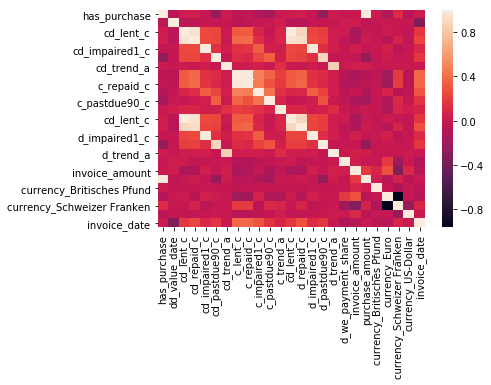

In [7]:
sns.heatmap(X_train_df.corr())

### SGD Classifier

In [8]:
#Linear model Stochastic Gradient Descent
sgd_clf = SGDClassifier(random_state=42, max_iter=250, loss='log', tol=0.0001) 
sgd_clf.fit(X_train, y_train)
sgd_clf_diag = model_diag(sgd_clf, X_train, y_train, CrossValFolds=5)

AUC 0.765


In [9]:
y_score_sgd = sgd_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_sgd)
print(cm)
sgd_test_diag = model_oostest(sgd_clf,X_test, y_test)
sgd_test_auc = plot_rocs([sgd_clf_diag, sgd_test_diag], p_width=600, p_height=600, model_appendix=['SGD - seq_valid','SGD - test'])
show(sgd_test_auc)

[[10652    20]
 [  798    52]]
Confusion matrix: 
[[0.99813 0.00187]
 [0.07478 0.00487]]
AUC 0.780


In [11]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

# max Number of iterations
max_iter = [100, 180, 200, 250, 300, 320, 350] 
# learning rate
learning_rate = ['constant', 'optimal', 'adaptive']
#eta
eta0 = [0.00001, 0.0001, 0.001, 0.01]
#loss
loss = ['log', 'hinge', 'perceptron']

param_grid = {'max_iter': max_iter,
               'learning_rate': learning_rate,
                  'eta0': eta0,
                  'loss':loss}

sgd = SGDClassifier(tol=0.0001)

sgd_gsearch = GridSearchCV(estimator = sgd, param_grid = param_grid, 
                           cv = 5, verbose=2, n_jobs =7, scoring=scoring, refit='AUC')
# Fit the random search model
sgd_gsearch.fit(X_train, y_train)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    5.7s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:   13.4s
[Parallel(n_jobs=7)]: Done 351 tasks      | elapsed:   33.7s
[Parallel(n_jobs=7)]: Done 634 tasks      | elapsed:   53.8s
[Parallel(n_jobs=7)]: Done 999 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done 1260 out of 1260 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True,
                                     tol=0.0001, validat...
                                     verbose=0, warm_start=False),
             iid='warn', n_jobs=7,
             param_grid={'eta0': [1e-05, 0.0001, 0.001, 0.01],
                         'learning_rate': ['constant', 'optimal', 'adaptive'],
                         'loss': ['log', 'hinge', 'perceptron'],
        

In [12]:
sgd_gsearch.best_params_

{'eta0': 0.01, 'learning_rate': 'adaptive', 'loss': 'log', 'max_iter': 180}

In [13]:
#Linear model Stochastic Gradient Descent
sgd_gs = SGDClassifier(random_state=42, max_iter=180, loss='log', learning_rate='adaptive', eta0=0.01, tol=0.0001) 
sgd_gs.fit(X_train, y_train)
sgd_gs_diag = model_diag(sgd_gs, X_train, y_train, CrossValFolds=5)

AUC 0.770


In [14]:
y_score_sgd_gs = sgd_gs.predict(X_test)
cm = confusion_matrix(y_test, y_score_sgd_gs)
print(cm)
sgd_test_diag_gs = model_oostest(sgd_gs,X_test, y_test)
sgd_test_auc_gs = plot_rocs([sgd_gs_diag, sgd_test_diag_gs], p_width=600, p_height=600, model_appendix=['SGD - crossvalid','SGD - test'])
show(sgd_test_auc_gs)

[[10642    30]
 [  796    54]]
Confusion matrix: 
[[0.99719 0.00281]
 [0.07459 0.00506]]
AUC 0.782


### Random Forest Classifier

In [15]:
#random forest - benchmark
n_estimators = 200
max_leaf_nodes = 40
rf_clf = RandomForestClassifier(random_state=42,
                               n_estimators=n_estimators,
                               max_leaf_nodes=max_leaf_nodes,
                               class_weight="balanced",
                               n_jobs=7)

rf_clf.fit(X_train, y_train)
rf_clf_diag = model_diag(rf_clf, X_train, y_train, CrossValFolds=5)

AUC 0.944


In [16]:
y_score_rf = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_rf)
print(cm)
rf_test_diag = model_oostest(rf_clf,X_test, y_test)
rf_test_auc = plot_rocs([rf_clf_diag, rf_test_diag], p_width=600, p_height=600, model_appendix=['RF - crossvalid','RF - test'])
show(rf_test_auc)

[[9175 1497]
 [  83  767]]
Confusion matrix: 
[[0.85973 0.14027]
 [0.00778 0.07187]]
AUC 0.946


### Randomized Grid Search

In [17]:
# Number of trees in random forest
n_estimators = [150, 180, 200, 250, 280, 300, 350] 
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 10, 20]
# Maximum number of levels in tree
max_depth = [100,200, None]
#Max leaf nodes
max_leaf_nodes = [10,20,40,60]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'max_leaf_nodes':max_leaf_nodes}

In [18]:
rf = RandomForestClassifier() #base model
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 80, 
                               cv = 5, 
                               verbose=2, random_state=42, n_jobs =7)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:  2.1min
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed: 10.2min
[Parallel(n_jobs=7)]: Done 351 tasks      | elapsed: 22.9min
[Parallel(n_jobs=7)]: Done 400 out of 400 | elapsed: 27.2min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [19]:
rf_random.best_params_

{'n_estimators': 280,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 60,
 'max_features': 20,
 'max_depth': 200,
 'bootstrap': True}

In [20]:
# Number of trees in random forest
n_estimators = [280, 300] 
# Number of features to consider at every split
max_features = [15, 20]
# Maximum number of levels in tree
max_depth = [200, 250, 280]
#Max leaf nodes
max_leaf_nodes = [60,80,100]
# Minimum number of samples required to split a node
min_samples_split = [10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'max_leaf_nodes':max_leaf_nodes}

In [21]:
rf = RandomForestClassifier() #base model
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, #param_distributions = sgd_random_grid, 
                           cv = 5,   
                                 verbose=2, n_jobs =7, scoring=scoring, refit='AUC')
# Fit the random search model
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:  3.2min
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed: 19.0min
[Parallel(n_jobs=7)]: Done 180 out of 180 | elapsed: 23.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=Fa...
                                              warm_start=False),
             iid='warn', n_jobs=7,
             param_grid={'bootstrap': [True], 'max_depth':

In [22]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 280,
 'max_features': 15,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 280}

In [23]:
#optimized params 
rf_opt = {'n_estimators': 280,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 100,
 'max_features': 15,
 'max_depth': 280,
 'bootstrap': True}

In [24]:
#random_forest from rand
n_estimators=rf_opt['n_estimators']
min_samples_split=rf_opt['min_samples_split']
min_samples_leaf=rf_opt['min_samples_leaf']
max_leaf_nodes=rf_opt['max_leaf_nodes']
max_features=rf_opt['max_features']
max_depth=rf_opt['max_depth']
bootstrap=rf_opt['bootstrap']




rf_opt_clf = RandomForestClassifier(random_state=42,
                               n_estimators=n_estimators,
                                max_features=max_features,
                                min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               class_weight="balanced", bootstrap=bootstrap,
                               n_jobs=7)
rf_opt_clf.fit(X_train, y_train)
rf_opt_diag = model_diag(rf_opt_clf, X_train, y_train, CrossValFolds=5)

AUC 0.979


In [25]:
y_score_rf_opt = rf_opt_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_rf_opt)
print(cm)
rf_opt_test_diag = model_oostest(rf_opt_clf,X_test, y_test)
rf_opt_test_auc = plot_rocs([rf_opt_diag, rf_opt_test_diag], p_width=600, p_height=600, model_appendix=['RF - val_seq','RF - test'])
show(rf_opt_test_auc)

[[10545   127]
 [  172   678]]
Confusion matrix: 
[[0.9881  0.0119 ]
 [0.01612 0.06353]]
AUC 0.981
